# Mini-projet 2 – Conditional Variational Autoencoders (CVAE)

Dans ce mini-projet, nous étudions les autoencodeurs variationnels conditionnels (*Conditional Variational Autoencoders*, ou **CVAEs**), qui constituent une extension du cadre des autoencodeurs variationnels standards (*Variational Autoencoders*, ou VAEs). Cette extension permet de conditionner la génération de données sur des informations supplémentaires, telles que des étiquettes de classe.

L’objectif principal de ce projet est de concevoir, implémenter et entraîner un modèle de CVAE, puis de l’appliquer au jeu de données Fashion-MNIST. En intégrant l’information de classe à la fois dans l’encodeur et dans le décodeur, le CVAE permet une génération contrôlée des données, rendant possible la production d’échantillons correspondant à des classes spécifiques.

Tout au long de ce projet, nous présentons les fondements théoriques des VAEs et de leur extension conditionnelle, justifions les choix architecturaux et les hyperparamètres utilisés, analysons les différents termes de la fonction de perte, et évaluons la qualité de l’espace latent appris à l’aide de visualisations et d’échantillons générés.

La section suivante est consacrée au cadre théorique nécessaire à la compréhension des autoencodeurs variationnels ainsi que de leur version conditionnelle.


# I. Cadre théorique – Autoencodeurs variationnels et conditionnels



## 1. De l’autoencodeur (AE) au Variational Autoencoder (VAE)

### 1.1 Autoencodeur classique

Un autoencodeur est constitué de deux composantes principales :

- un **encodeur**, qui projette une observation $x$ dans un espace latent de dimension réduite, noté $z$ ;
- un **décodeur**, qui reconstruit une approximation $\hat{x}$ de l’entrée originale à partir de cette représentation latente.

Le modèle est entraîné de manière à ce que la reconstruction $\hat{x}$ soit aussi proche que possible de $x$. Une fonction de perte couramment utilisée est l’erreur quadratique moyenne (MSE)

$$
\mathcal{L}_{AE}(x) = \|x - \hat{x}\|^2.
$$

Les autoencodeurs permettent ainsi d’apprendre des représentations compactes des données. Toutefois :

- aucune contrainte n’est imposée sur la structure de l’espace latent ;
- le modèle n’est pas véritablement génératif : un point $z$ tiré arbitrairement dans l’espace latent n’est pas garanti de produire une observation réaliste.


### 1.2 Vers un espace latent probabiliste : le VAE

Le Variational Autoencoder (VAE) introduit une idée fondamentale :  
**l’encodeur ne produit plus un vecteur latent déterministe, mais une distribution de probabilité sur l’espace latent.**

Pour chaque observation $x$, l’encodeur paramétrise une distribution latente de la forme

$$
q_\phi(z \mid x) = \mathcal{N}\big(\mu(x),\, \sigma^2(x) I\big),
$$

où $\mu(x)$ et $\sigma(x)$ sont des fonctions apprises par le réseau.

Afin de permettre l’apprentissage par descente de gradient, on utilise le **trick de reparamétrisation**

$$
z = \mu(x) + \sigma(x)\,\varepsilon, \qquad \varepsilon \sim \mathcal{N}(0, I).
$$

Le décodeur définit ensuite une distribution conditionnelle sur les données, notée $p_\theta(x \mid z)$.

L’entraînement du VAE repose sur la maximisation de la **borne inférieure de la vraisemblance marginale** (*Evidence Lower Bound*, ELBO). En pratique, on minimise la loss négative suivante

$$
\mathcal{L}_{VAE}(x)
= - \mathbb{E}_{q_\phi(z \mid x)}\big[\log p_\theta(x \mid z)\big]
+ \mathrm{KL}\big(q_\phi(z \mid x)\,\|\,p(z)\big),
$$

où $p(z) = \mathcal{N}(0, I)$ est le prior sur les variables latentes.

Le premier terme correspond à la perte de reconstruction, tandis que le second terme régularise l’espace latent en forçant les distributions latentes à rester proches du prior.

Cette régularisation permet ensuite de générer de nouvelles observations réalistes en échantillonnant simplement
$
z \sim \mathcal{N}(0, I).
$



## 2. Le Conditional Variational Autoencoder (CVAE)

Un VAE classique permet de générer de nouvelles images, mais **sans aucun contrôle sur la classe produite**.  
Par exemple, en échantillonnant un vecteur latent $z \sim \mathcal{N}(0, I)$, il n’est pas possible d’imposer au modèle de générer spécifiquement une chaussure, un pantalon ou un pull.

Le Conditional Variational Autoencoder (CVAE) répond à cette limitation en introduisant une **variable de conditionnement** $y$, telle que la classe associée à l’image.

### 2.1 Principe du CVAE

Dans un CVAE, l’encodeur et le décodeur sont tous deux **conditionnés par le label $y$**, en plus de l’image $x$.

- L’encodeur approxime une distribution latente conditionnelle

$$
q_\phi(z \mid x, y).
$$

- Le décodeur modélise la distribution conditionnelle des données

$$
p_\theta(x \mid z, y).
$$

Dans le cas du jeu de données **Fashion-MNIST**, le label $y$ est généralement représenté sous la forme d’un **vecteur one-hot** de dimension 10, correspondant aux différentes classes.


### 2.2 Intérêt du conditionnement sur $y$

Dans un VAE classique, la variable latente $z$ doit capturer simultanément :

- l’information de classe (pantalon, chaussure, etc.) ;
- les variations intra-classe (style, forme, épaisseur, orientation).

Dans un CVAE, la classe $y$ étant fournie explicitement au modèle,  
**la variable latente $z$ n’a plus besoin d’encoder l’information de classe**.  
Elle se concentre uniquement sur les variations fines *au sein d’une même classe*.

Ce découplage entraîne plusieurs avantages :

- un espace latent plus **structuré** et plus **interprétable** ;
- une génération **contrôlée** par la classe ;
- une stabilité accrue lors de l’entraînement.

### 2.3 Génération conditionnelle

Une fois le modèle entraîné, la génération conditionnelle d’une image s’effectue en trois étapes :

1. choisir un label $y$ correspondant à la classe désirée ;
2. échantillonner un vecteur latent

$$
z \sim \mathcal{N}(0, I) ;
$$

3. fournir le couple $(z, y)$ au décodeur

$$
\hat{x} = \text{Decoder}(z, y).
$$

Le modèle génère alors une image réaliste appartenant à la classe $y$, dont le style dépend du vecteur latent $z$.

### 2.4 Fonction de perte du CVAE et pondération du terme KL

Comme pour le VAE, l’apprentissage du CVAE repose sur la maximisation d’une borne inférieure de la vraisemblance marginale (ELBO). En pratique, cela revient à minimiser une fonction de perte composée de deux termes principaux.

1. **La perte de reconstruction conditionnelle**, qui mesure la capacité du modèle à reconstruire correctement l’image $x$ à partir du vecteur latent $z$ et du label $y$

$$
\mathcal{L}_{\text{recon}}(x, y)
= - \mathbb{E}_{q_\phi(z \mid x, y)} \left[ \log p_\theta(x \mid z, y) \right].
$$

Ce terme garantit que l’image reconstruite $\hat{x}$ est fidèle à l’image d’entrée, conditionnellement à la classe.

2. **La divergence de Kullback–Leibler**, qui régularise l’espace latent en forçant la distribution latente approchée à rester proche d’un prior gaussien standard

$$
\mathrm{KL}\big(q_\phi(z \mid x, y) \,\|\, p(z)\big),
\qquad \text{avec } p(z) = \mathcal{N}(0, I).
$$

Afin de mieux contrôler le compromis entre fidélité de reconstruction et régularisation de l’espace latent, on introduit un **facteur de pondération $\beta$ devant le terme de divergence de Kullback–Leibler.

La fonction de perte finale du CVAE utilisée dans ce projet s’écrit donc

$$
\mathcal{L}_{\text{CVAE}}(x, y)
=
\mathcal{L}_{\text{recon}}(x, y)
+
\beta \, \mathrm{KL}\big(q_\phi(z \mid x, y) \,\|\, \mathcal{N}(0, I)\big).
$$

Le paramètre $\beta > 0$ permet d’ajuster l’importance relative de la régularisation :

- pour $\beta << 1$, la priorité est donnée à la qualité de reconstruction ;
- pour $\beta >> 1$, l’espace latent est davantage régularisé, au prix d’une reconstruction parfois moins précise.

Dans ce projet, l’utilisation de $\beta$ permet d’analyser l’influence du terme KL sur la structure de l’espace latent et sur la qualité de la génération conditionnelle.


## II. Prétraitement des données

### 1 Présentation du jeu de données Fashion-MNIST

Dans ce mini-projet, nous utilisons le jeu de données Fashion-MNIST, disponible via le module
`torchvision.datasets`. Ce jeu de données a été conçu comme une alternative plus réaliste au jeu
MNIST classique, tout en conservant une structure similaire, notamment des images de petite taille
en niveaux de gris.

Fashion-MNIST est composé d’images représentant différents types de vêtements et d’accessoires,
répartis en plusieurs catégories.

#### 1.1 Description des données:

Le jeu de données Fashion-MNIST contient :

- 70 000 images au total ;
- des images de taille 28 × 28 pixels ;
- des images en niveaux de gris ;
- 10 classes correspondant à différentes catégories de vêtements.

La répartition initiale des données est la suivante :

- 60 000 images pour l’apprentissage ;
- 10 000 images pour le test.

Afin de sélectionner les hyperparamètres du modèle et d’éviter toute sur-optimisation sur le jeu de
test, l’ensemble d’apprentissage est ensuite scindé en trois parties :

- ensemble d’entraînement : 50 000 images ;
- ensemble de validation : 10 000 images ;
- ensemble de test : 10 000 images.

L’ensemble de validation est utilisé pour comparer différentes configurations du modèle, tandis que
l’ensemble de test est réservé à l’évaluation finale du modèle.

#### 1.2 Prétraitement des données:

Les images sont converties en tenseurs PyTorch et normalisées dans l’intervalle [0,1] à l’aide de la
transformation `ToTensor()`. Ce prétraitement est adapté au cadre des autoencodeurs variationnels,
en particulier lorsque la fonction de reconstruction repose sur une Binary Cross-Entropy.

#### 1.3 Chargement des données:

Les ensembles d’entraînement, de validation et de test sont chargés à l’aide de la classe
`DataLoader`. Cela permet un entraînement par mini-batchs et un accès efficace aux données lors des
différentes phases d’apprentissage et d’évaluation.


Le code suivant illustre le chargement du jeu de données Fashion-MNIST ainsi que la création des DataLoaders utilisés pour l’entraînement, la validation et le test du modèle.


In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import torch.nn.functional as F
import warnings
import os
from torchvision.utils import save_image
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import itertools
!pip install torch-fidelity

from torch_fidelity import calculate_metrics

# Ignore all warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
batch_size = 64

## Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

# Split train_dataset into train and validation sets
train_size = 50000
val_size   = 10000
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Les tailles des différents ensembles sont ensuite vérifiées afin de s’assurer que la séparation des données a été correctement effectuée.


In [ ]:

print(f"Nombre d'images dans le train set : {len(train_dataset)}")
print(f"Nombre d'images dans le validation set : {len(val_dataset)}")
print(f"Nombre d'images dans le test set : {len(test_dataset)}")


Nombre d'images dans le train set : 50000
Nombre d'images dans le validation set : 10000
Nombre d'images dans le test set : 10000


Les noms des classes sont définis afin de faciliter l’interprétation et l’affichage des résultats.


In [ ]:

class_names = [
    "T-shirt", "Pantalon", "Pull", "Robe", "Manteau",
    "Sandale", "Chemise", "Basket", "Sac", "Bottine"
]


### 2 Exploration des données
Avant l’entraînement du Conditional Variational Autoencoder (CVAE),nous faisons  une exploration préliminaire
du jeu de données Fashion-MNIST afin de mieux comprendre la nature des images et la
répartition des classes. Elle permet de vérifier la cohérence des données et de s’assurer
qu’elles sont adaptées à notre modèle.



Le code suivant permet d’afficher quelques exemples d’images issues du jeu d’entraînement, accompagnées de leurs labels, afin de visualiser les différentes classes présentes dans le jeu de données.


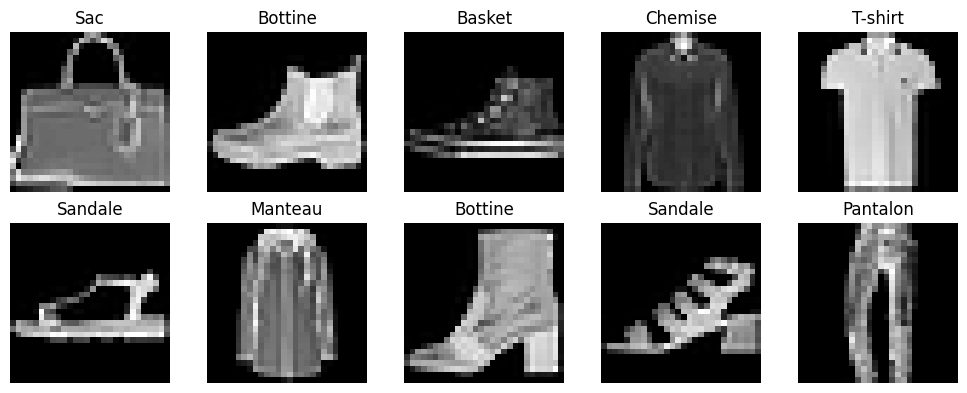

In [ ]:

#  Affichage de quelques exemples d'images

images, labels = next(iter(train_loader))

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(class_names[labels[i].item()])
    plt.axis("off")

plt.tight_layout()
plt.show()


Les images sont de faible résolution et contiennent peu de détails. Malgré cela, le modèle CVAE est capable d’apprendre une structure latente pertinente et de générer de nouvelles images en tenant compte de la classe associée.


#### 2.1 Répartition des classes

Afin de vérifier l’équilibre des classes dans les différents ensembles, nous analysons la distribution des labels dans les jeux d’entraînement, de validation et de test.


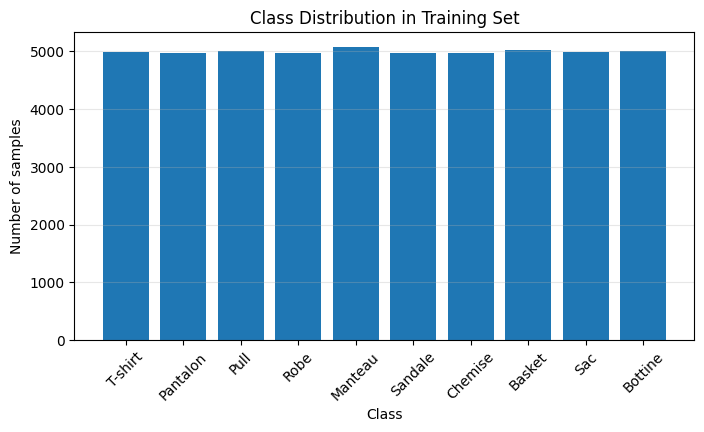

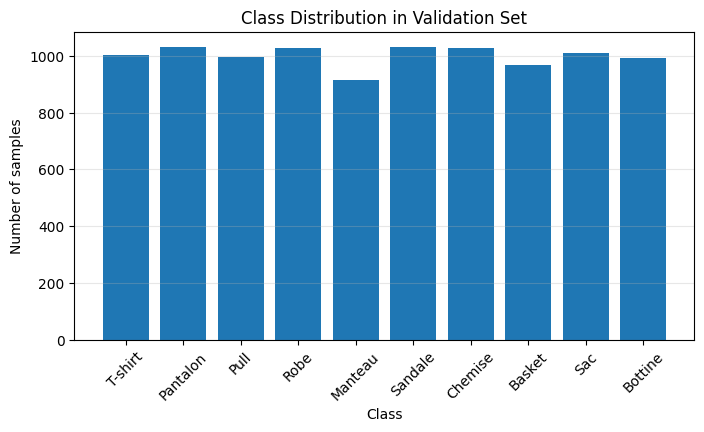

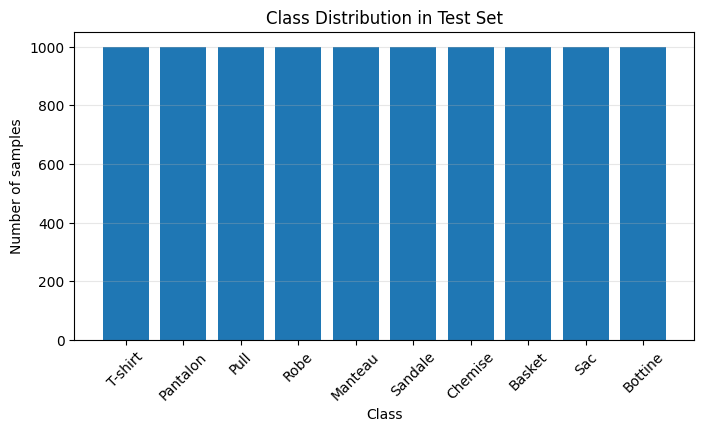

In [ ]:

# Training set

train_labels = [label for _, label in train_dataset]
train_counts = np.bincount(train_labels, minlength=len(class_names))

plt.figure(figsize=(8, 4))
plt.bar(range(len(class_names)), train_counts)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Distribution in Training Set")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Validation set
val_labels = [label for _, label in val_dataset]
val_counts = np.bincount(val_labels, minlength=len(class_names))

plt.figure(figsize=(8, 4))
plt.bar(range(len(class_names)), val_counts)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Distribution in Validation Set")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Test set

test_labels = [label for _, label in test_dataset]
test_counts = np.bincount(test_labels, minlength=len(class_names))

plt.figure(figsize=(8, 4))
plt.bar(range(len(class_names)), test_counts)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Distribution in Test Set")
plt.grid(axis="y", alpha=0.3)
plt.show()

Le jeu de données Fashion-MNIST se prête particulièrement bien à l’apprentissage d’un autoencodeur variationnel conditionnel. Chaque image est associée à une étiquette de classe, ce qui permet de conditionner explicitement le modèle et de contrôler la classe des images générées. Les différentes catégories de vêtements présentent des structures visuelles distinctes. Au sein d’une même classe, les images présentent des différences visibles, notamment en termes de forme et d’apparence. Le label permet donc d’indiquer au modèle quelle classe générer, tandis que la variable latente sert à introduire de la diversité entre les images produites. Par ailleurs, les classes étant réparties de manière relativement équilibrée, le modèle ne favorise pas une catégorie en particulier lors de la génération.


## III. Modèle CVAE


### 1 Architecture du modèle

L’architecture du Conditional Variational Autoencoder (CVAE) utilisée dans ce projet est inspirée du Variational Autoencoder convolutionnel étudié lors des travaux pratiques du cours.

Le modèle est composé de trois blocs principaux : un encodeur , un espace latent , et un décodeur .

**Encodeur :**  
L’encodeur repose sur une architecture convolutionnelle (CNN), car ce type de réseau est particulièrement adapté à l’analyse d’images. Les convolutions permettent d’extraire efficacement des caractéristiques visuelles pertinentes tout en préservant la structure spatiale des données.

**Espace latent :**  
L’espace latent est implémenté à l’aide de couches entièrement connectées afin de transformer les représentations extraites par l’encodeur en une description globale des données.

**Décodeur :**  
Le décodeur utilise également une architecture convolutionnelle, symétrique à celle de l’encodeur, afin de reconstruire les images à partir de la représentation latente.


In [ ]:
class ConvCVAE(nn.Module):
    def __init__(self, latent_dim=10, condition_dim=10):
        super(ConvCVAE, self).__init__()

        # Dimension de l’espace latent z
        self.latent_dim = latent_dim

        # Dimension du vecteur de condition (10 classes pour Fashion-MNIST)
        self.condition_dim = condition_dim

        # Encoder

        self.encoder = nn.Sequential(
            # Première couche : extraction de motifs locaux (bords, textures simples)
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # -> (32, 14, 14)
            nn.BatchNorm2d(32),  # Stabilise l’apprentissage
            nn.ReLU(),           # Introduit la non-linéarité

            # Deuxième couche : motifs plus abstraits (formes, parties d’objets)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # -> (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Troisième couche : représentation compacte et riche
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # -> (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )


        # Latent space (Fully Connected layers)

        # Après l’encodeur, la représentation est aplatie puis concaténée
        # avec le vecteur de condition c (one-hot).
        # Cela permet d’apprendre la distribution q(z | x, c).
        self.fc_mu = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)

        # Cette couche projette le vecteur latent z (conditionné par c)
        # vers une représentation compatible avec le décodeur
        self.fc_decode = nn.Linear(latent_dim + condition_dim, 128 * 4 * 4)


        # Decoder

        # Le décodeur utilise des convolutions transposées afin de reconstruire
        # progressivement l’image en restaurant sa structure spatiale.
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # -> (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Dernière couche : reconstruction de l’image en niveaux de gris
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # -> (1, 28, 28)
            nn.Sigmoid()
        )

    # Encoder forward pass

    def encode(self, x, y):
        """
        Encode l’image x conditionnée par la classe c.
        Implémente q(z | x, c).
        """
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4)
        c = c = F.one_hot(y, num_classes=self.condition_dim).float()
        x = torch.cat([x, c], dim=1)

        # Estimation des paramètres de la distribution latente
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    # Reparameterization trick

    def sample(self, mu, logvar):
        """
        Échantillonnage de z à partir de  N(mu, sigma^2) en utilisant le reparameterization trick
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    # Decoder forward pass

    def decode(self, z, y):
        """
        Reconstruit l’image à partir du vecteur latent z conditionné par la classe c.
         Implémente p(x | z, c).
        """

        c = F.one_hot(y, num_classes=self.condition_dim).float()

        z = torch.cat([z, c], dim=1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)

        # Reconstruction progressive de l’image
        x = self.decoder(x)
        return x

    # Forward pass

    def forward(self, x, y):
        """
        x -> encode -> sample -> decode
        """
        mu, logvar = self.encode(x, y)
        z = self.sample(mu, logvar)
        return self.decode(z, y), mu, logvar


## 2 Entraînement du CVAE


###  2.1 Fonction de perte du CVAE

L’apprentissage du Conditional Variational Autoencoder repose sur la minimisation d’une
fonction de perte composée de deux termes : une perte de reconstruction et un terme de
régularisation basé sur la divergence de Kullback–Leibler.

La fonction de perte du CVAE s’écrit
$$
\mathcal{L}_{\text{CVAE}} =
\mathcal{L}_{\text{recon}} + \beta\mathcal{L}_{\text{KL}}.
$$

Le terme de reconstruction mesure la similarité entre l’image d’entrée $x$ et l’image
reconstruite $\hat{x}$. Étant donné que les images sont normalisées dans l’intervalle
$[0,1]$, nous utilisons la Binary Cross-Entropy
$$
\mathcal{L}_{\text{recon}} =
-\sum \big[ x \log(\hat{x}) + (1 - x)\log(1 - \hat{x}) \big].
$$

Le terme de régularisation correspond à la divergence de Kullback–Leibler entre la
distribution latente apprise $q_\phi(z \mid x, y)$ et la loi normale standard
$\mathcal{N}(0, I)$
$$
\mathcal{L}_{\text{KL}} =
-\frac{1}{2} \sum \left(1 + \log \sigma^2 - \mu^2 - \sigma^2 \right).
$$

Ce terme contraint l’espace latent à rester proche d’une distribution gaussienne, ce qui
facilite la génération d’images cohérentes lors de l’échantillonnage.


In [ ]:
# Implement the loss function
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD


### 2.2 Sélection des hyperparamètres par grid search

Nous avons effectué une recherche par grille (*grid search*) afin d’étudier  l’influence de plusieurs hyperparamètres du CVAE sur ses performances.

Les hyperparamètres considérés sont :
- la dimension de l’espace latent ($d_z$),
- le poids du terme de régularisation KL ($\beta$).

Le taux d’apprentissage et le nombre d’époques sont fixés afin de garantir une comparaison équitable entre les différentes configurations.

Pour chaque combinaison d’hyperparamètres, le modèle est entraîné pendant un nombre fixe d’époques. À chaque époque :
- la fonction de perte est minimisée sur l’ensemble d’entraînement (mise à jour des poids),
- puis évaluée sur l’ensemble de validation, sans mise à jour des paramètres.

La fonction de perte utilisée est :
$$
\mathcal{L} = \mathcal{L}_{\text{BCE}} + \beta \, \mathcal{L}_{\text{KL}},
$$
où $\mathcal{L}_{\text{BCE}}$ mesure l’erreur de reconstruction et $\mathcal{L}_{\text{KL}}$ régularise l’espace latent.

Le meilleur modèle est sélectionné comme celui présentant la plus faible perte de validation finale, ce critère permettant d’identifier la configuration offrant le meilleur compromis entre qualité de reconstruction et capacité de généralisation, sans utiliser le jeu de test.

In [ ]:

SAVE_PATH = "best_cvae_model.pth"


In [ ]:

# Grid search parameters

latent_dims = [8, 16, 32]
betas = [0.25, 0.5, 1.0, 2.0]
learning_rate = 1e-3
epochs = 5

best_config = None
lowest_val_loss = float("inf")
best_losses = None  # pour stocker les courbes du meilleur modèle

# Grid search loop

for latent_dim, beta in itertools.product(latent_dims, betas):

    print(f"\nTraining CVAE | latent_dim={latent_dim}, beta={beta}")

    model = ConvCVAE(latent_dim=latent_dim, condition_dim= 10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    total_losses = []
    recon_losses = []
    kl_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):

        # TRAIN
        model.train()
        epoch_total, epoch_recon, epoch_kl = 0.0, 0.0, 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            recon_x, mu, logvar = model(x, y)
            loss, bce, kld = loss_function_cvae(recon_x, x, mu, logvar, beta)

            loss.backward()
            optimizer.step()

            epoch_total += loss.item()
            epoch_recon += bce.item()
            epoch_kl += kld.item()

        n_train = len(train_loader.dataset)
        train_total = epoch_total / n_train
        train_recon = epoch_recon / n_train
        train_kl = epoch_kl / n_train

        total_losses.append(train_total)
        recon_losses.append(train_recon)
        kl_losses.append(train_kl)

        #  VALIDATION
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)

                recon_x, mu, logvar = model(x, y)
                loss, _, _ = loss_function_cvae(recon_x, x, mu, logvar, beta)
                val_loss += loss.item()

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train total={train_total:.4f} | "
            f"Recon={train_recon:.4f} | "
            f"KL={train_kl:.4f} | "
            f"Val={val_loss:.4f}"
        )

    # Track best model

    if val_losses[-1] < lowest_val_loss:
        lowest_val_loss = val_losses[-1]
        best_config = {
            "latent_dim": latent_dim,
            "beta": beta,
            "learning_rate": learning_rate,
            "epochs": epochs
        }
        best_losses = {
            "total": total_losses,
            "recon": recon_losses,
            "kl": kl_losses,
            "val": val_losses
        }
        torch.save(model.state_dict(), SAVE_PATH)





Training CVAE | latent_dim=8, beta=0.25
Epoch 1/5 | Train total=245.2777 | Recon=240.3176 | KL=19.8405 | Val=234.6002
Epoch 2/5 | Train total=232.0386 | Recon=227.0106 | KL=20.1119 | Val=230.2854
Epoch 3/5 | Train total=229.7296 | Recon=224.7198 | KL=20.0390 | Val=229.8615
Epoch 4/5 | Train total=228.4025 | Recon=223.4090 | KL=19.9743 | Val=227.9459
Epoch 5/5 | Train total=227.4519 | Recon=222.4739 | KL=19.9118 | Val=226.9963

Training CVAE | latent_dim=8, beta=0.5
Epoch 1/5 | Train total=251.0006 | Recon=243.1091 | KL=15.7830 | Val=238.5978
Epoch 2/5 | Train total=236.7290 | Recon=228.6738 | KL=16.1103 | Val=235.5878
Epoch 3/5 | Train total=234.4450 | Recon=226.3806 | KL=16.1288 | Val=233.5464
Epoch 4/5 | Train total=233.1337 | Recon=225.1064 | KL=16.0546 | Val=232.6904
Epoch 5/5 | Train total=232.1531 | Recon=224.1531 | KL=16.0000 | Val=232.3104

Training CVAE | latent_dim=8, beta=1.0
Epoch 1/5 | Train total=260.6729 | Recon=248.7502 | KL=11.9227 | Val=246.8043
Epoch 2/5 | Train tot


GRID SEARCH COMPLETE
Best configuration: {'latent_dim': 16, 'beta': 0.25, 'learning_rate': 0.001, 'epochs': 5}
Lowest validation loss: 223.5119


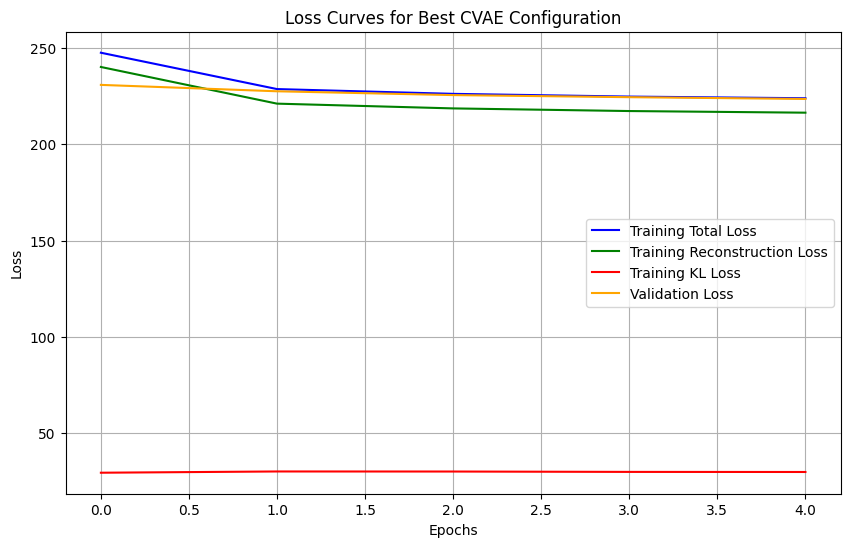

In [ ]:
print("\nGRID SEARCH COMPLETE")
print(f"Best configuration: {best_config}")
print(f"Lowest validation loss: {lowest_val_loss:.4f}")


# Plot best model losses

plt.figure(figsize=(10, 6))
plt.plot(best_losses["total"], label="Training Total Loss", color="b")
plt.plot(best_losses["recon"], label="Training Reconstruction Loss", color="g")
plt.plot(best_losses["kl"], label="Training KL Loss", color="r")
plt.plot(best_losses["val"], label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for Best CVAE Configuration")
plt.legend()
plt.grid(True)
plt.show()


La diminution de la perte totale est principalement due à la baisse de la perte de reconstruction, qui reste dominante tout au long de l’entraînement. Le terme KL varie peu, ce qui suggère que l’apprentissage se concentre surtout sur l’amélioration des reconstructions. Ce comportement sera approfondi lors de l’analyse de l’espace latent.


Le paramètre
*$\beta$* contrôle le compromis entre la qualité de reconstruction et la régularisation de l’espace latent en pondérant le terme de divergence de Kullback–Leibler dans la fonction de perte.

### 2.3 Entraînement du modèle avec les hyperparamètres optimisés

À l’issue de la recherche d’hyperparamètres, le modèle est entraîné en utilisant la configuration offrant les meilleures performances sur l’ensemble de validation. Cette configuration correspond au meilleur compromis entre la qualité de reconstruction et la régularisation de l’espace latent.

Une fois les hyperparamètres sélectionnés, le modèle CVAE correspondant est réentraîné sur un plus grand nombre d’époques afin d’assurer une convergence satisfaisante. Cette phase d’entraînement final permet au modèle d’exploiter pleinement sa capacité de représentation et d’obtenir un apprentissage stable avant l’analyse des résultats de génération.


In [ ]:

# Load best configuration

latent_dim = best_config["latent_dim"]
beta = best_config["beta"]
learning_rate = best_config["learning_rate"]

# Rebuild model

model = ConvCVAE(
    latent_dim=latent_dim,
    condition_dim=10
).to(device)

model.load_state_dict(torch.load(SAVE_PATH))

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Best model loaded successfully")
print(best_config)


Best model loaded successfully
{'latent_dim': 16, 'beta': 0.25, 'learning_rate': 0.001, 'epochs': 5}


### 2.4 Entraînement final
Après sélection des hyperparamètres sur validation, le CVAE est réentraîné from scratch sur l’ensemble d’apprentissage complet (train+val), sur davantage d’époques ( ici on chosit 40 epoques )


In [ ]:

# Final training

final_epochs = 40

total_losses = []
recon_losses = []
kl_losses = []
val_losses = []

for epoch in range(1, final_epochs + 1):

    #  TRAIN
    model.train()
    epoch_total, epoch_recon, epoch_kl = 0.0, 0.0, 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        recon_x, mu, logvar = model(x, y)
        loss, bce, kld = loss_function_cvae(recon_x, x, mu, logvar, beta)

        loss.backward()
        optimizer.step()

        epoch_total += loss.item()
        epoch_recon += bce.item()
        epoch_kl += kld.item()

    n_train = len(train_loader.dataset)
    total_losses.append(epoch_total / n_train)
    recon_losses.append(epoch_recon / n_train)
    kl_losses.append(epoch_kl / n_train)

    #  VALIDATION
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            recon_x, mu, logvar = model(x, y)
            loss, _, _ = loss_function_cvae(recon_x, x, mu, logvar, beta)
            val_loss += loss.item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch}/{final_epochs} | "
        f"Train total={total_losses[-1]:.4f} | "
        f"Recon={recon_losses[-1]:.4f} | "
        f"KL={kl_losses[-1]:.4f} | "
        f"Val={val_losses[-1]:.4f}"
    )
FINAL_PATH = "final_cvae.pth"
torch.save(model.state_dict(), FINAL_PATH)
print("Final CVAE model saved successfully")


Epoch 1/40 | Train total=223.4346 | Recon=215.9744 | KL=29.8407 | Val=223.6083
Epoch 2/40 | Train total=222.7255 | Recon=215.2877 | KL=29.7512 | Val=222.3060
Epoch 3/40 | Train total=222.2475 | Recon=214.8339 | KL=29.6543 | Val=222.1819
Epoch 4/40 | Train total=221.8477 | Recon=214.4358 | KL=29.6476 | Val=221.6960
Epoch 5/40 | Train total=221.4994 | Recon=214.1103 | KL=29.5562 | Val=221.4538
Epoch 6/40 | Train total=221.1738 | Recon=213.8075 | KL=29.4653 | Val=221.4570
Epoch 7/40 | Train total=220.9788 | Recon=213.6253 | KL=29.4137 | Val=221.1415
Epoch 8/40 | Train total=220.7401 | Recon=213.3976 | KL=29.3701 | Val=220.9294
Epoch 9/40 | Train total=220.5507 | Recon=213.2281 | KL=29.2904 | Val=220.5304
Epoch 10/40 | Train total=220.3612 | Recon=213.0362 | KL=29.3002 | Val=220.6207
Epoch 11/40 | Train total=220.2178 | Recon=212.9131 | KL=29.2185 | Val=220.4633
Epoch 12/40 | Train total=220.0547 | Recon=212.7495 | KL=29.2210 | Val=220.9040
Epoch 13/40 | Train total=219.9117 | Recon=212.61

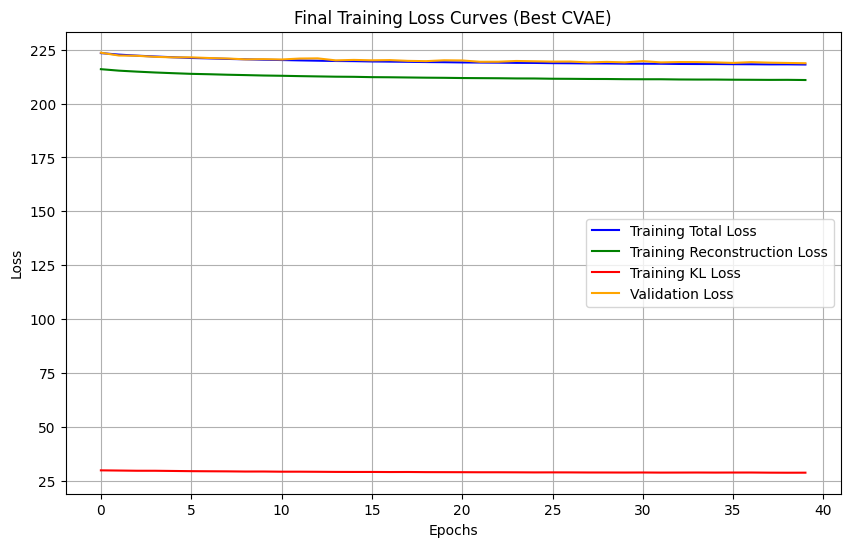

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(total_losses, label="Training Total Loss", color="b")
plt.plot(recon_losses, label="Training Reconstruction Loss", color="g")
plt.plot(kl_losses, label="Training KL Loss", color="r")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Final Training Loss Curves (Best CVAE)")
plt.legend()
plt.grid(True)
plt.show()


Les courbes d’apprentissage montrent que le modèle CVAE converge de manière stable après environ 20 à 40 epochs. Les pertes d’entraînement et de validation diminuent simultanément et restent très proches l’une de l’autre, ce qui indique l’absence de surapprentissage et une bonne capacité de généralisation du modèle. La perte de reconstruction continue de diminuer lentement durant la phase de *fine-tuning*, traduisant une amélioration progressive de la qualité de reconstruction.

Par ailleurs, la divergence de Kullback–Leibler demeure stable et strictement positive, ce qui montre que la variable latente \(z\) conserve des informations pertinentes sur les données d’entrée et qu’elle est effectivement exploitée par le décodeur. Cela signifie que le modèle ne présente pas de phénomène de *posterior collapse*, c’est-à-dire que l’espace latent ne s’effondre pas vers la distribution a priori \( \mathcal{N}(0,I) \) et n’est pas ignoré par le décodeur. L’espace latent est ainsi bien structuré et permet la génération de données variées.

Ces observations confirment que le modèle a atteint un état de convergence stable à l’issue de l’entraînement final.


In [ ]:
# Load final trained model
cvae = ConvCVAE(
    latent_dim=latent_dim,
    condition_dim=10
).to(device)

cvae.load_state_dict(torch.load(FINAL_PATH))
cvae.eval()

print("Final CVAE model loaded successfully")


Final CVAE model loaded successfully


# III Résultats

Dans cette section, nous utilisons une fonction fournie dans le TP afin de visualiser et comparer les images originales avec leurs reconstructions produites par le modèle CVAE.


In [ ]:

def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(10, 5))

    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Recomstruction')

    plt.tight_layout()
    plt.show()


Nous appliquons ensuite le modèle entraîné à un batch d’images du jeu de test afin de visualiser les reconstructions obtenues.


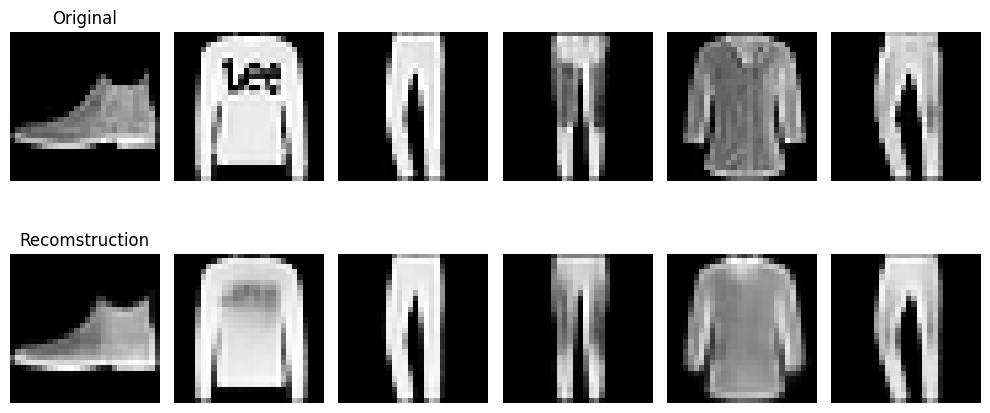

In [ ]:
# Récupération d'un batch du jeu de test
images, labels = next(iter(test_loader))

images = images.to(device)
labels = labels.to(device)



# Reconstruction
with torch.no_grad():
    reconstructions, _, _ = cvae(images, labels)

# Conversion pour affichage
images_np = images.cpu().numpy().squeeze()
recons_np = reconstructions.cpu().numpy().squeeze()

# Affichage
image_comparison(images_np, recons_np)


## 1 Visualisation des images generées

In [ ]:
def generate_samples(num_samples=10):
    model.eval()

    with torch.no_grad():
        # Latent vectors
        z = torch.randn(num_samples, model.latent_dim).to(device)

        # Random class labels (integers)
        labels = torch.randint(0, 10, (num_samples,), dtype=torch.long).to(device)

        # Decode
        samples = model.decode(z, labels)

    # Display
    fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))

    for i in range(num_samples):
        ax[i].imshow(samples[i].cpu().squeeze(), cmap="gray")
        ax[i].set_title(class_names[labels[i].item()], fontsize=9)
        ax[i].axis("off")

    plt.suptitle("Generated samples with random classes", fontsize=14)
    plt.show()


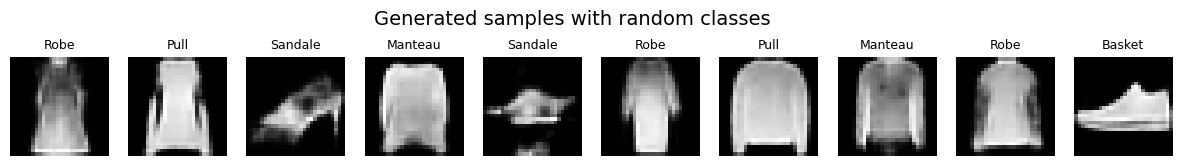

In [ ]:
generate_samples()


## 2. Generation d'images par classes

In [ ]:
def generate_samples_per_class(num_samples_per_class=5):
    model.eval()

    with torch.no_grad():
        fig, ax = plt.subplots(
            10, num_samples_per_class,
            figsize=(2 * num_samples_per_class, 20)
        )

        for class_idx in range(10):
            # Latent vectors
            z = torch.randn(num_samples_per_class, model.latent_dim).to(device)

            # Labels entiers (pas one-hot)
            labels = torch.full(
                (num_samples_per_class,),
                class_idx,
                dtype=torch.long
            ).to(device)

            # Génération
            samples = model.decode(z, labels)

            for i in range(num_samples_per_class):
                ax[class_idx, i].imshow(
                    samples[i].cpu().squeeze(), cmap="gray"
                )
                ax[class_idx, i].axis("off")

                # Titre seulement sur la première image de chaque ligne
                if i == 0:
                    ax[class_idx, i].set_ylabel(
                        class_names[class_idx],
                        fontsize=12,
                        rotation=0,
                        labelpad=40
                    )

        plt.suptitle(
            "Conditional generation: samples per class",
            fontsize=16
        )
        plt.tight_layout()
        plt.show()

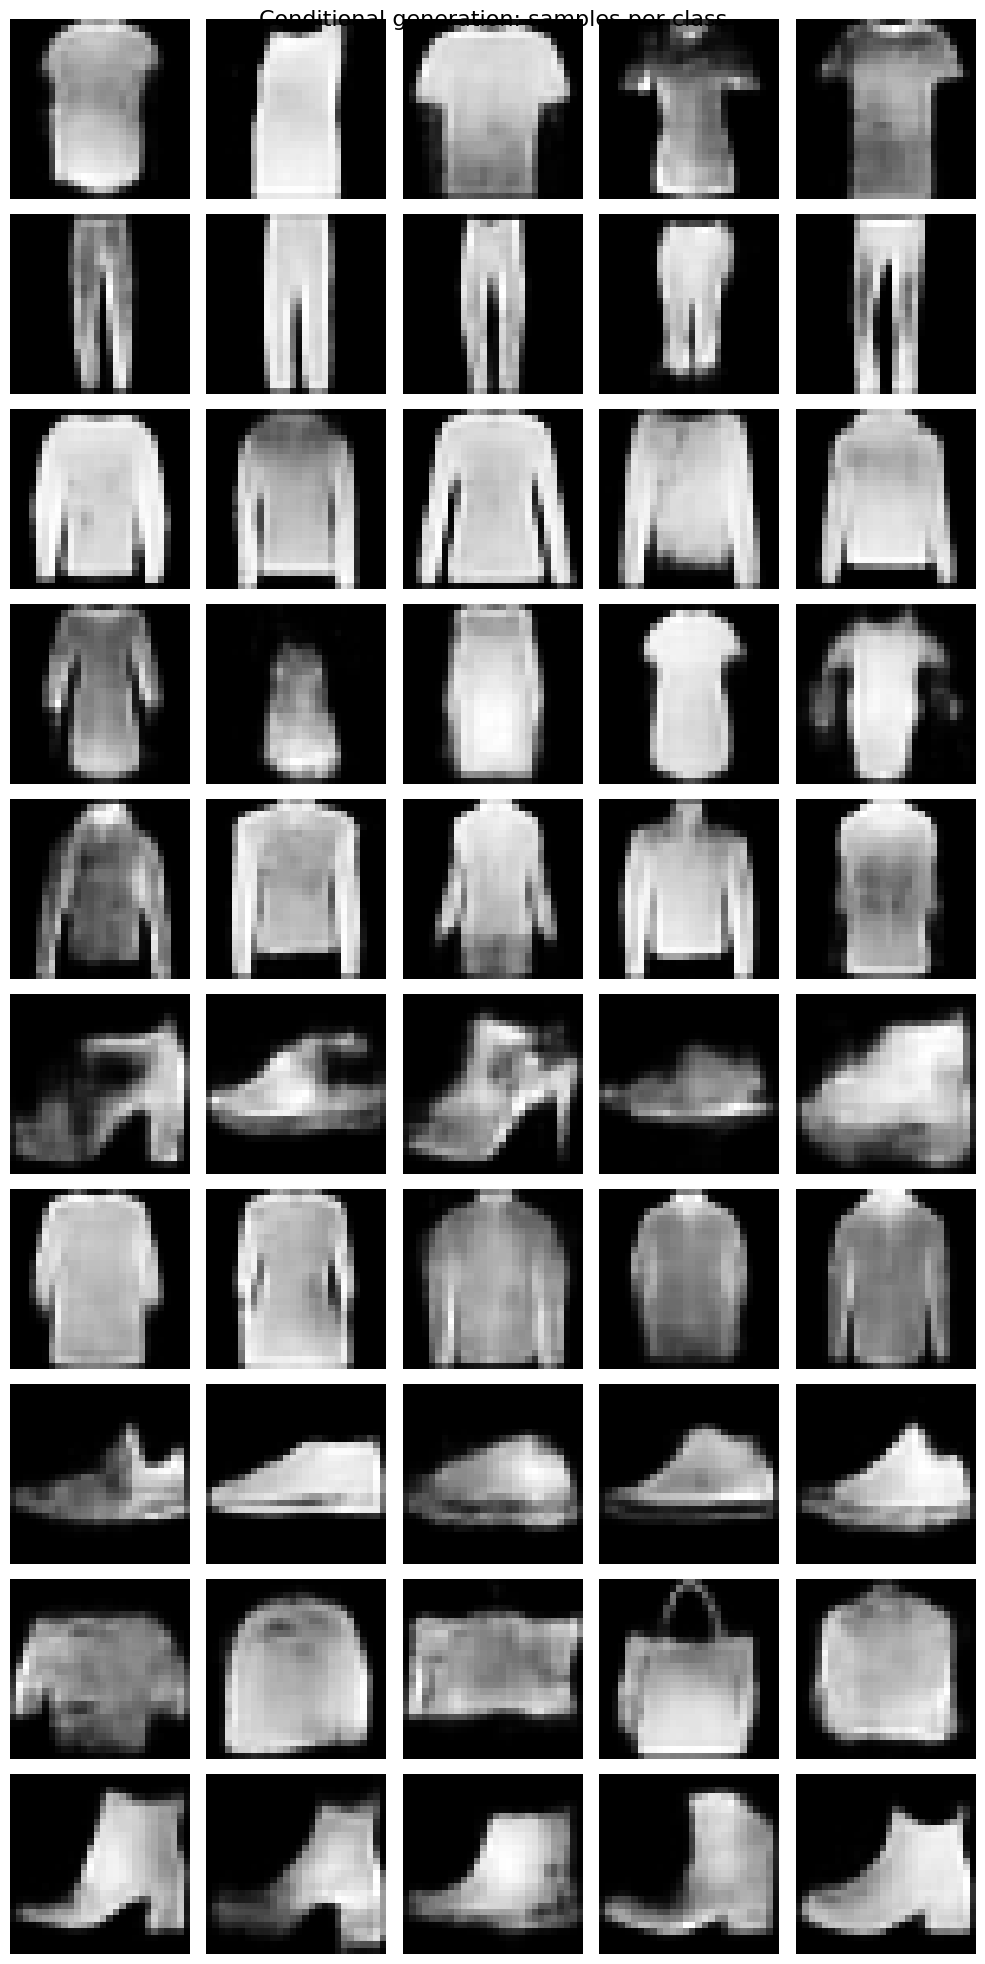

In [ ]:
generate_samples_per_class(num_samples_per_class=5)


## 3 Visualisation de l’espace latent

Afin d’analyser l’influence du poids du terme de divergence de Kullback–Leibler, plusieurs modèles CVAE ont été entraînés avec une dimension latente fixée à 2 et différentes valeurs de β. Ce choix permet une visualisation directe de l’espace latent et facilite l’interprétation de l’effet de la régularisation sur la structure des représentations apprises.


In [ ]:
latent_dim = 2
condition_dim = 10
kl_weights = [ 0.5,1.0, 100]
num_epochs = 20
learning_rate = 1e-3


In [ ]:
def plot_latent_space_cvae(model, test_loader, beta):
    model.eval()
    with torch.no_grad():
        all_mu = []
        all_labels = []

        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            mu, _ = model.encode(x, y)
            all_mu.append(mu.cpu())
            all_labels.append(y.cpu())

        z = torch.cat(all_mu).numpy()
        labels = torch.cat(all_labels).numpy()

        plt.figure(figsize=(7, 6))
        scatter = plt.scatter(
            z[:, 0], z[:, 1],
            c=labels,
            cmap="tab10",
            alpha=0.6
        )
        plt.colorbar(scatter, ticks=range(10))
        plt.title(f"Espace latent du CVAE (β = {beta})")
        plt.xlabel("$z_1$")
        plt.ylabel("$z_2$")
        plt.grid(True)
        plt.show()



Training CVAE with beta = 0.5
Epoch 1/20 | Loss = 268.3198
Epoch 2/20 | Loss = 256.2098
Epoch 3/20 | Loss = 254.5003
Epoch 4/20 | Loss = 253.4031
Epoch 5/20 | Loss = 252.6808
Epoch 6/20 | Loss = 252.0640
Epoch 7/20 | Loss = 251.6664
Epoch 8/20 | Loss = 251.1880
Epoch 9/20 | Loss = 250.7156
Epoch 10/20 | Loss = 250.5083
Epoch 11/20 | Loss = 250.1909
Epoch 12/20 | Loss = 249.9431
Epoch 13/20 | Loss = 249.6232
Epoch 14/20 | Loss = 249.5086
Epoch 15/20 | Loss = 249.2772
Epoch 16/20 | Loss = 249.1200
Epoch 17/20 | Loss = 248.8163
Epoch 18/20 | Loss = 248.6602
Epoch 19/20 | Loss = 248.4645
Epoch 20/20 | Loss = 248.4519


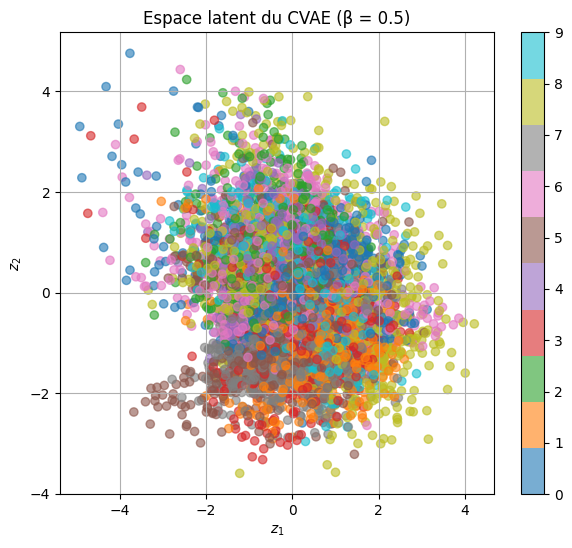


Training CVAE with beta = 1.0
Epoch 1/20 | Loss = 270.0534
Epoch 2/20 | Loss = 258.4165
Epoch 3/20 | Loss = 256.5328
Epoch 4/20 | Loss = 255.2695
Epoch 5/20 | Loss = 254.5339
Epoch 6/20 | Loss = 253.9064
Epoch 7/20 | Loss = 253.5856
Epoch 8/20 | Loss = 253.1860
Epoch 9/20 | Loss = 252.8792
Epoch 10/20 | Loss = 252.6347
Epoch 11/20 | Loss = 252.4088
Epoch 12/20 | Loss = 252.0400
Epoch 13/20 | Loss = 251.9020
Epoch 14/20 | Loss = 251.7888
Epoch 15/20 | Loss = 251.5482
Epoch 16/20 | Loss = 251.3667
Epoch 17/20 | Loss = 251.2462
Epoch 18/20 | Loss = 251.0615
Epoch 19/20 | Loss = 250.9292
Epoch 20/20 | Loss = 250.8245


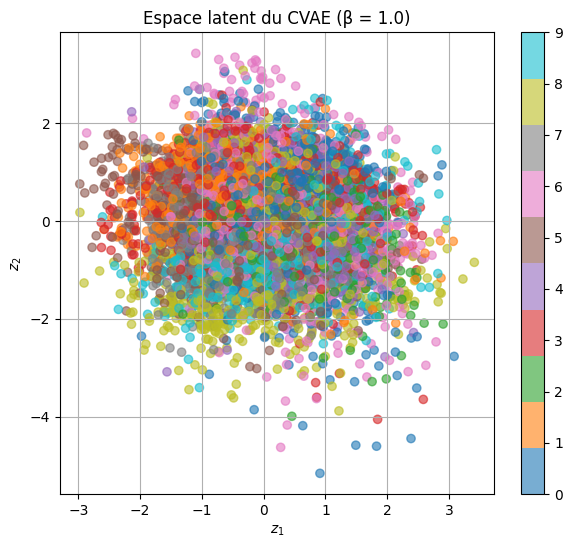


Training CVAE with beta = 100
Epoch 1/20 | Loss = 315.6353
Epoch 2/20 | Loss = 308.2971
Epoch 3/20 | Loss = 307.9836
Epoch 4/20 | Loss = 307.8242
Epoch 5/20 | Loss = 307.7586
Epoch 6/20 | Loss = 307.7289
Epoch 7/20 | Loss = 307.6260
Epoch 8/20 | Loss = 307.6120
Epoch 9/20 | Loss = 307.5808
Epoch 10/20 | Loss = 307.5354
Epoch 11/20 | Loss = 307.5175
Epoch 12/20 | Loss = 307.4887
Epoch 13/20 | Loss = 307.4560
Epoch 14/20 | Loss = 307.4429
Epoch 15/20 | Loss = 307.4399
Epoch 16/20 | Loss = 307.4236
Epoch 17/20 | Loss = 307.3808
Epoch 18/20 | Loss = 307.3516
Epoch 19/20 | Loss = 307.3793
Epoch 20/20 | Loss = 307.3477


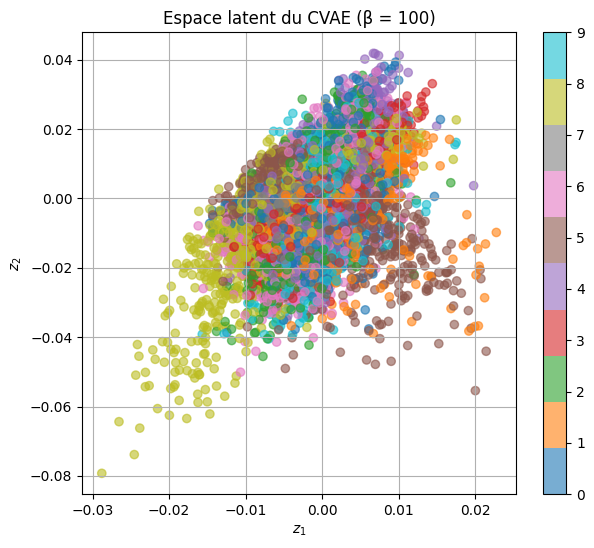

In [ ]:
for beta in kl_weights:
    print(f"\nTraining CVAE with beta = {beta}")

    model = ConvCVAE(latent_dim=latent_dim, condition_dim=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            recon_x, mu, logvar = model(x, y)
            loss, _, _ = loss_function_cvae(recon_x, x, mu, logvar, beta)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Loss = {epoch_loss / len(train_loader.dataset):.4f}"
        )

    # Visualisation de l'espace latent
    plot_latent_space_cvae(model, test_loader, beta)


L’analyse de l’espace latent met en évidence l’effet du poids $\beta$ associé au terme de divergence KL.

Pour des valeurs faibles de $\beta$, l’espace latent est fortement dispersé et peu structuré, indiquant que le modèle utilise largement les variables latentes pour encoder l’information, au détriment de la régularisation.

À mesure que $\beta$ augmente, l’espace latent devient plus compact et mieux régularisé autour du prior gaussien, traduisant un compromis plus équilibré entre reconstruction et régularisation.

En revanche, pour des valeurs élevées de $\beta$, la contrainte KL domine la fonction de perte, conduisant à une contraction excessive de l’espace latent et à une perte d’information, phénomène proche du posterior collapse.


 Les fichiers de poids se trouvent à l’adresse suivante : https://drive.google.com/drive/folders/1d_hw58Z4lV6RGWT9YcRm6MXrtrHXaPes

## Liens des ressources utilisées

https://github.com/Samgeorge2003/Conditional-Variational-Autoencoder-CVAE/blob/main/Conditional%20Variational%20Autoencoder%20(CVAE).ipynbµ


https://www.youtube.com/watch?v=W4peyiOaEFU&t=459s

https://www.codegenes.net/blog/cvae-pytorch/

https://pyro.ai/examples/cvae.html

https://nugg.ad/fr/glossaire-ia/autoencodeurs-variatoires-conditionnels/

https://beckham.nz/2023/04/27/conditional-vaes.html
